<a href="https://colab.research.google.com/github/enznoor/AnomalyDetection/blob/main/FP_Libra_CMDModel_MyModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dgl

In [ ]:
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import networkx as nx
import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import torch.nn.functional as F
import pandas as pd
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
#from dgl.nn import GraphConv
#from dgl.nn import SAGEConv
import dgl.nn as dglnn
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score , roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
import itertools

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BasePath='drive/MyDrive/Term_05/FinalProject/Dataset/'
nodedf=pd.read_csv(BasePath + 'LibraNodeInfo.csv')
edgedf=pd.read_csv(BasePath + 'LibraEdgeInfo.csv')
Vedgedf=pd.read_csv(BasePath + 'VirtualEdge.csv')
CMAdf=pd.read_csv(BasePath + 'ListAnomalComunity.csv')
#CMdf=pd.read_csv(BasePath + 'partitions_GemList.csv')

In [ ]:
print(edgedf.shape)
print(nodedf.shape)

(597165, 6)
(385100, 21)


In [ ]:
train, validate, test = np.split(CMAdf.sample(frac=1), [int(.6*len(CMAdf)), int(.8*len(CMAdf))])

train_idx=torch.tensor(train.index, dtype = torch.long)
test_idx=torch.tensor(test.index, dtype = torch.long)
valid_idx=torch.tensor(validate.index, dtype = torch.long)

In [ ]:
CMAdf

,Index,SizeCM,CntAnomalNode
0,0,4,0
1,1,7,0
2,2,38810,24
3,3,9427,13
4,4,3,0
...,...,...,...
8296,8296,2,0
8297,8297,2,0
8298,8298,2,0
8299,8299,2,0


In [ ]:
G = nx.Graph()
nodes=[item for item in CMAdf.Index]
G.add_nodes_from(nodes, color='red')
src = [index for index in Vedgedf['source_id']]
dst = [index for index in Vedgedf['destination_id']]
edgelist = list(itertools.zip_longest(src, dst ))


for nodeA , nodeB in edgelist:
    #B=B+1
    if nodeA in G.nodes() and nodeB in G.nodes():
        G.add_edge(nodeA,nodeB)
print('number_of_edges: ',G.number_of_edges())
print('number_of_nodes: ',G.number_of_nodes())
#nx.draw_networkx(G)

number_of_edges:  2925
number_of_nodes:  8301


#Extract needed information from the dataset

In [ ]:
def Get_DataMask(df):
    mask=[]
    for i in CMAdf.index:
        if i in df.index:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [ ]:
CMAdf.shape

(8301, 3)

In [ ]:
#AttrEge=['cum_amount', 'nr_transactions']
G=nx.from_pandas_edgelist(
            df=Vedgedf,
            source="source_id",
            target="destination_id",
            #edge_attr=AttrEge,
            create_using=nx.DiGraph
        )
print('number_of_edges: ',G.number_of_edges())
print('number_of_nodes: ',G.number_of_nodes())

number_of_edges:  4777
number_of_nodes:  190


In [ ]:
graph = dgl.DGLGraph(G)

/usr/local/lib/python3.10/dist-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


In [ ]:
CMAdf

,Index,SizeCM,CntAnomalNode
0,0,4,0
1,1,7,0
2,2,38810,24
3,3,9427,13
4,4,3,0
...,...,...,...
8296,8296,2,0
8297,8297,2,0
8298,8298,2,0
8299,8299,2,0


In [ ]:
featurename=['SizeCM']


In [ ]:
CMAdf.shape

(8301, 3)

In [ ]:
node_features=torch.tensor(CMAdf[featurename].values , dtype = torch.float)
graph.ndata['feat'] = node_features
type(graph.ndata['feat'])

torch.Tensor

In [ ]:
#graph.edata['AttrEge'] = torch.tensor(edgedf["cum_amount"].values)

In [ ]:
CMAdf["label"] = np.where(CMAdf["CntAnomalNode"] > 0, 1, 0)

In [ ]:
label = torch.tensor(CMAdf["label"].values)
graph.ndata['label'] = label
type(label)

torch.Tensor

In [ ]:
train_mask=Get_DataMask(train)
test_mask=Get_DataMask(test)
val_mask=Get_DataMask(validate)

In [ ]:
node_features = graph.ndata['feat']
node_labels = graph.ndata['label']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

In [ ]:
graph.ndata['train_mask']=torch.tensor(train_mask)
graph.ndata['test_mask']=torch.tensor(test_mask)
graph.ndata['val_mask']=torch.tensor(val_mask)
edgelist=torch.tensor(edgedf[["id_source", "id_destination" ]].values)
#graph.edata['edg'] = edgelist

In [ ]:
graph

Graph(num_nodes=8301, num_edges=5850,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})

# Create Model

In [ ]:
# Define a simple Graph Convolutional Network (GCN) model for anomaly detection
class GAGNNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GAGNNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, features):
        with g.local_scope():
            g.ndata['h'] = features
            g.update_all(fn.copy_u('h', 'm'), fn.sum('m', 'h_sum'))
            h = g.ndata['h']
            return self.linear(h)

class GAGNNModel(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GAGNNModel, self).__init__()
        self.layer1 = GAGNNLayer(in_feats, hidden_size)
        self.layer2 = GAGNNLayer(hidden_size, num_classes)

    def forward(self, g, features):
        x = torch.relu(self.layer1(g, features))
        x = self.layer2(g, x)
        return x

In [ ]:
def evaluate(model, graph, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(graph, features)

    logits = logits[mask]
    labels = labels[mask]

    _, predicted = torch.max(logits, 1)

    accuracy = (predicted == labels).float().mean().item()
    print(classification_report(labels, predicted))

    #--------------------Plot AUC----------------------------
    fpr, tpr, thresholds = roc_curve(labels, predicted)

    # Calculate the AUC
    roc_auc = auc(fpr, tpr)
    # Calculate the AUC
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for GAGNN Model')
    plt.legend(loc='lower right')
    plt.show()


    return accuracy

In [ ]:
#model = SAGE(in_feats=n_features, hid_feats=100, out_feats=n_labels)
#opt = torch.optim.Adam(model.parameters())

In [ ]:
best_val_acc = 0
best_test_acc = 0

features_train = graph.ndata["feat"]
labels = graph.ndata["label"]
train_mask = graph.ndata["train_mask"]
val_mask = graph.ndata["val_mask"]
test_mask = graph.ndata["test_mask"]
#**********************New For chart*********************
EPOCHS=5
loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_labels=torch.unique(labels)
class_labels=np.array(class_labels)
y=labels
y=np.array(y)
class_weights =compute_class_weight(class_weight='balanced', classes=class_labels, y=y)

class_weights=torch.tensor(class_weights ,  dtype = torch.float)


In [ ]:
num_classes=2
in_feats = features_train.shape[1]
hid_feats = 16 # Hidden layer size
out_feats = num_classes  # Number of output classes

# Define and train the model
model = GAGNNModel(in_feats=in_feats, hidden_size=hid_feats, num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
#criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss for binary classification
# Assuming you have a set of labeled anomalies in your dataset (replace 'anomaly_labels' accordingly)
anomaly_labels = torch.zeros_like(labels)
anomaly_class = 1
# Identify indices of anomalies in the training set
anomaly_indices = torch.tensor([i for i, label in enumerate(labels) if label == anomaly_class])
# Convert to a tensor if needed
anomaly_indices = torch.tensor(anomaly_indices)

<ipython-input-51-5516434b7161>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  anomaly_indices = torch.tensor(anomaly_indices)


In epoch 0, loss: 0.096)
In epoch 5, loss: 0.000)
In epoch 10, loss: 0.000)
In epoch 15, loss: 0.000)
In epoch 20, loss: 0.000)
In epoch 25, loss: 0.102)
In epoch 30, loss: 0.000)
In epoch 35, loss: 0.001)
In epoch 40, loss: 0.001)
In epoch 45, loss: 0.001)


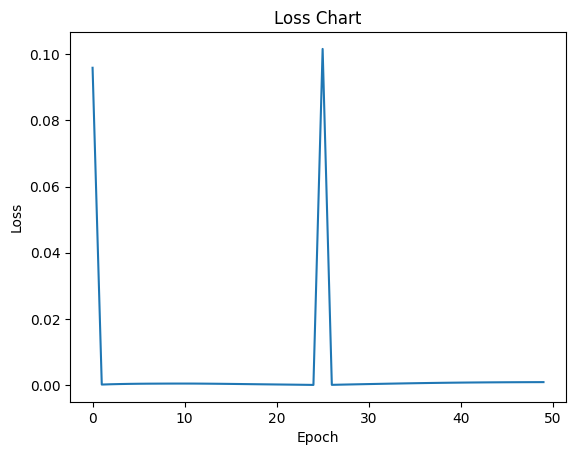

In [ ]:
num_epochs=50
loss_list: list = []
epochlist = np.zeros((num_epochs,))
# Training loop
for epoch in range(num_epochs):
    model.train()
    logits = model(graph, features_train)
    loss = criterion(logits[train_mask], labels[train_mask]) / len(train)
    loss_list.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f"In epoch {epoch}, loss: {loss:.3f})"
            )
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Chart')
plt.show()


              precision    recall  f1-score   support

           0       1.00      0.86      0.92      1645
           1       0.06      0.94      0.11        16

    accuracy                           0.86      1661
   macro avg       0.53      0.90      0.52      1661
weighted avg       0.99      0.86      0.91      1661



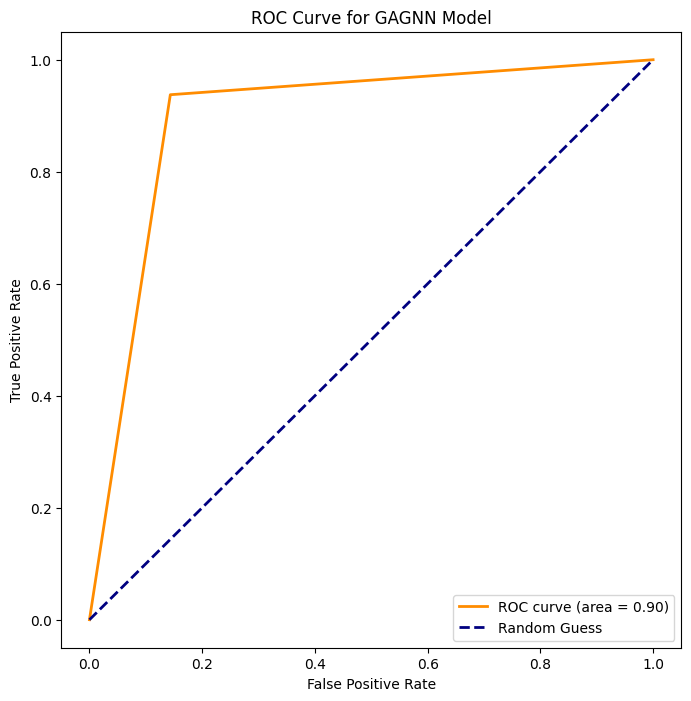

Test Accuracy: 0.8573


In [ ]:
# Evaluate on the test set
model.eval()
mask_test = (graph.ndata['test_mask'] == True)  # Assuming you have a test mask
accuracy = evaluate(model, graph, features_train, labels, mask_test)

print(f"Test Accuracy: {accuracy:.4f}")